# Optimization of a Renewable Electricity Supply System for IIT Kharagpur's campus

## Bachelor's Thesis Project (BTP - I)  [Autumn 2022]
Debraj Chatterjee (19IM10039) 

Department of Industrial and Systems Engineering,

IIT Kharagpur



### **Project Objective -** 

To optimize a hybrid solar-wind energy supply system for IIT Kharagpur's campus based upon the conflicting objectives of - 

 

1.   Minimization of **Total System Cost (TSC)**
2.   Minimization of **Probability of Loss of Power Supply (LPSP)**

Since the objectives are conflicting in nature, this is a multi-objective optimization problem. 

The algorithm to be used for optimization is **NSGA-II** (Non-Dominated Sorting Algorithm - II).





### Installation of Libraries and Defining Helper Functions

In [1]:
import numpy as np
import pandas as pd
! pip install pymoo    
#pymoo stands for python multi-objective optimization library. 
#It is the best library for multiobjective optimization out there.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Data Pre-Processing and Input 

Three kinds of data points are required for the project - 


1.   KGP Campus' Electricity Consumption Data
2.   Kharagpur's Climate Data
3.   Properties of photovaltaic module and wind turbine



1) Electricity Consumption Data

In [2]:
#Helper Function for Data Pre-Processing
#This function has been written to divide the monthly consumption data into the 
#day-time and night-time consumption for each period

#monthly_consumption = List of month-wise electricity consumption
#n_days = List of days in a month
#day_percentage = % of total daily electricity that is consumed during day-time

def period_wise_consumption_list_maker(monthly_consumption,n_days,day_percentage):
  result = []
  for i in range(n_days*2):
    if i%2 !=0: #If period is odd, it means day time
      result.append((monthly_consumption/n_days)*day_percentage)
    else: #If period is even, it means night time
      result.append((monthly_consumption/n_days)*(1-day_percentage))
  
  return result

In [3]:
#Year under consideration = 2025

Months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
Aut_Sem_Months = ['Aug','Sep','Oct','Nov'] #Autumn Semester Months
Spr_Sem_Months = ['Jan','Feb','Mar','Apr'] #Spring Semester Months
Off_Sem_Months = ['May','Jun','Jul','Dec'] #Off-Semester Months
On_Months = [Month for Month in Months if Month not in Off_Sem_Months]

#Electricity Consumption Data for 2025
total_elec_consump = 66715796   #kWh Arrived at by forecasting from past data for 2025
Aut_Sem_Percentage = 0.5      # % of total annual consumed during autumn semester
Spr_Sem_Percentage = 0.4      # % of total annual consumed during spring semester
Off_Month_Percentage = 1-(Aut_Sem_Percentage + Spr_Sem_Percentage)    
#Total = 0.5 + 0.4 + 0.1 = 100%

Day_Time_Percentage = 0.7 # % of daily consumption, consumed during day-time
Night_Time_Percentage = 1 - Day_Time_Percentage


Aut_Sem_Total = total_elec_consump*Aut_Sem_Percentage
Spr_Sem_Total = total_elec_consump*Spr_Sem_Percentage
Off_Month_Total = total_elec_consump*Off_Month_Percentage

Days_in_Month = {
                       'Jan' : 31,
                       'Feb' : 28,
                       'Mar' : 31,
                       'Apr' : 30,
                       'May' : 31,
                       'Jun' : 30,
                       'Jul' : 31,
                       'Aug' : 31,
                       'Sep' : 30,
                       'Oct' : 31,
                       'Nov' : 30,
                       'Dec' : 31,
                      }

Aut_Sem_Days = sum(values for (keys,values) in Days_in_Month.items() if keys in Aut_Sem_Months)
Spr_Sem_Days = sum(values for (keys,values) in Days_in_Month.items() if keys in Spr_Sem_Months)
Off_Sem_Days = sum(values for (keys,values) in Days_in_Month.items() if keys in Off_Sem_Months)


Monthly_Consumption = {
                       'Jan' : Spr_Sem_Total*(Days_in_Month['Jan']/Spr_Sem_Days),
                       'Feb' : Spr_Sem_Total*(Days_in_Month['Feb']/Spr_Sem_Days),
                       'Mar' : Spr_Sem_Total*(Days_in_Month['Mar']/Spr_Sem_Days),
                       'Apr' : Spr_Sem_Total*(Days_in_Month['Apr']/Spr_Sem_Days),
                       'May' :Off_Month_Total*(Days_in_Month['May']/Off_Sem_Days),
                       'Jun' :Off_Month_Total*(Days_in_Month['Jun']/Off_Sem_Days),
                       'Jul' :Off_Month_Total*(Days_in_Month['Jul']/Off_Sem_Days),
                       'Aug' :Aut_Sem_Total*(Days_in_Month['Aug']/Aut_Sem_Days),
                       'Sep' :Aut_Sem_Total*(Days_in_Month['Sep']/Aut_Sem_Days),
                       'Oct' :Aut_Sem_Total*(Days_in_Month['Oct']/Aut_Sem_Days),
                       'Nov' :Aut_Sem_Total*(Days_in_Month['Nov']/Aut_Sem_Days),
                       'Dec' :Off_Month_Total*(Days_in_Month['Feb']/Off_Sem_Days)
                      }



Periods_in_Month = {k:v*2 for (k,v) in Days_in_Month.items()} #Each day has 2 periods - Day and Night
Period_length = 12 #12 hours per period

Monthly_Period_Wise_Consumption = {
                                  k:period_wise_consumption_list_maker(Monthly_Consumption[k],Days_in_Month[k],Day_Time_Percentage) 
                                  for k in Days_in_Month.keys()
                                  }
            
Monthly_Period_Wise_Consumption_list = []
for month in Months:
  Monthly_Period_Wise_Consumption_list = Monthly_Period_Wise_Consumption_list + Monthly_Period_Wise_Consumption[month]

Monthly_Period_Wise_Consumption_list = np.array(Monthly_Period_Wise_Consumption_list)
Monthly_Period_Wise_Consumption_list = Monthly_Period_Wise_Consumption_list/Period_length #Power = Energy/Time
                              

2) Kharagpur's Climate Data

In [4]:
#Month Wise Weather Data 

#Format = {Month : (Night Time Temp (Min), Day Time Temp (Max), Wind Speed Day, Wind Speed Night,  Solar Radiation)}
Monthly_Weather_Data = {
                        'Jan' : (14,27,3.65,8,725.5),
                        'Feb' : (17,31,3.65,8.3,808.5),
                        'Mar' : (22,34,4.25,9,893.5),
                        'Apr' : (24,36,5.7,13,939.5),
                        'May' : (25,36,6.7,15,940.5),
                        'Jun' : (26,34,6.05,13.5,928.5),
                        'Jul' : (26,32,5.4,11.8,925.5),
                        'Aug' : (26,32,4.75,10.2,924.5),
                        'Sep' : (25,32,4.05,8.6,894),
                        'Oct' : (23,32,3.3,7,821),
                        'Nov' : (19,31,3.3,7.5,736.5),
                        'Dec' : (15,28,3.7,8.2,694)
                     }


In [5]:
Period_wise_temperature = []
Period_wise_wind = []
Period_wise_solar = []
for month in Months:
  for i in range(Periods_in_Month[month]):
    if i%2==0: #Means Night
      Period_wise_temperature.append(Monthly_Weather_Data[month][0])
      Period_wise_wind.append(Monthly_Weather_Data[month][3])
      Period_wise_solar.append(int(0))
    else: #Means Day
      Period_wise_temperature.append(Monthly_Weather_Data[month][1])
      Period_wise_wind.append(Monthly_Weather_Data[month][2])
      Period_wise_solar.append(Monthly_Weather_Data[month][4])
Period_wise_temperature = np.array(Period_wise_temperature)
Period_wise_wind = np.array(Period_wise_wind)
Period_wise_solar = np.array(Period_wise_solar)


3) Properties of Photovoltaic Module and Wind Turbine
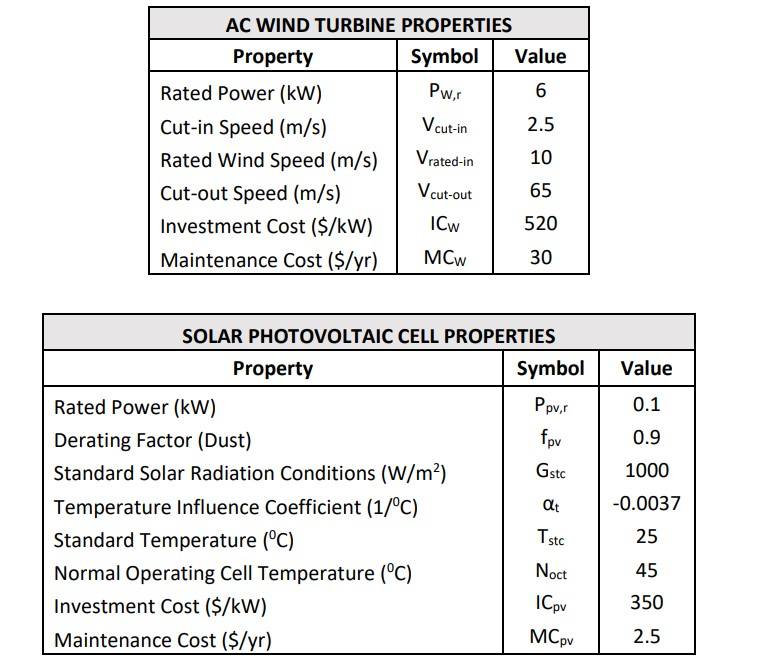

In [6]:
#Windmill
P_w_rated = 6 #kW
V_cut_in = 2.5*3.6 #2.5 m/s x 3.6 km/hr per m/s
V_rated = 10*3.6
V_cut_out = 65*3.6
IC_w = 520 #Unit price of windmill = 520 US$/kW_rated
MC_w = 30 #Maintenance cost = 30USD/yr
# RC_w = 0 Don't think will include Replacement cost into the picture - just find breakeven

#PV Module
P_pv_rated = 0.1 #kW
f_pv = 0.9 #Derating factor due to dust
G_stc = 1000 #W/m2 Solar radiation under standard conditions
alpha_t = -0.0037 #1/degree C temperature influence coefficient for monocrystalline and polycrystalline silicon
T_stc = 25 #degree C standard temp of PV module
N_oct = 45 #degree C, Normal Operating Cell Temperature

#Need to make equation for T using T_ambient later

IC_pv = 350 #USD/kW rated
MC_pv = 2.5 #USD/year


# #Battery Pack (Although not sure whether will actually include in the finale or not)
# #Each battery bank will have 120 2V/1000Ah batteries to give 240 V
# P_bat_max = 1000 #Ah
# bat_efficiency = 0.85
# sigma = 0.0003 #%loss due to leakage in battery
invert_efficiency = 0.95 #Inverter efficiency
convert_efficiency = 0.95 #Convertor efficiency

# IC_bat = 1500 #USD/kAh
# MC_bat = 10 #USD/year


### Defining Objective Functions



Windmill Power Generation Function

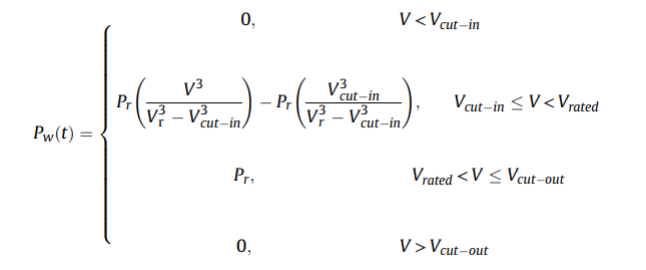

In [7]:
def wind_power(P_rated,V_cut_in,V_rated,V_cut_out,V):
  """Function to calculate the wind power in a time period"""
  power = 0
  if(V<V_cut_in):
    power = 0
  if(V_cut_in<=V and V<V_rated):
    power = P_rated*(V**3 / (V_rated**3 - V_cut_in**3)) - P_rated*(V_cut_in**3 / (V_rated**3 - V_cut_in**3))

  if(V_rated<V and V<=V_cut_out):
    power = P_rated

  if(V>V_cut_out):
    power = 0
  
  return power

PV Module Power Generation Function
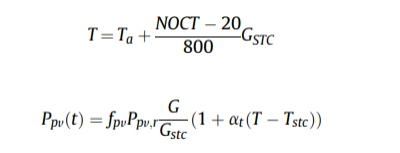

In [8]:
def solar_power(T_alpha,G,N_oct,alpha_t,T_stc,G_stc,f_pv,P_pv_rated):
  """Function to calculate PV module power"""
  T = T_alpha + (N_oct - 20)*(G_stc/800)

  power = f_pv*P_pv_rated*(G/G_stc)*(1 + alpha_t*(T-T_stc))
  return power

In [9]:
period_solar_power = np.zeros(730)
period_wind_power = np.zeros(730)
period_power = np.zeros(730)

for i in range(730):
  period_solar_power[i] = solar_power(Period_wise_temperature[i],
                                   Period_wise_solar[i],
                                   N_oct,alpha_t,T_stc,G_stc,f_pv,P_pv_rated)
  
  period_wind_power[i] = wind_power(P_w_rated,V_cut_in,V_rated,V_cut_out,Period_wise_wind[i])

Objective Function 1 - **Total System Cost (TSC)**

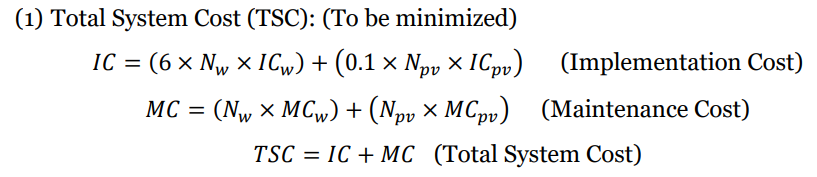

In [10]:
def total_system_cost(N_w,N_pv):
  IC = 6*N_w*IC_w + 0.1*N_pv*IC_pv #Investment Cost
  MC = N_w*MC_w + N_pv*MC_pv       #Maintenance Cost
  return (IC + MC)

Objective Function 2 - **Loss of Power Supply Probability (LPSP)**

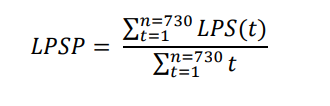

In [11]:
def LPSP(N_w,N_pv):
  LPS = np.zeros(730)
  for i in range(730):
    if ((N_pv*period_solar_power[i]*120*convert_efficiency*invert_efficiency + 
         N_w*period_wind_power[i]*convert_efficiency)>=
         Monthly_Period_Wise_Consumption_list[i]):
      LPS[i] = 0
      #if (i<729):
        #Monthly_Period_Wise_Consumption_list[i+1] = max(0,Monthly_Period_Wise_Consumption_list[i+1] - (N_w*period_solar_power[i]*120*convert_efficiency*invert_efficiency + 
        #N_pv*period_wind_power[i]*convert_efficiency - Monthly_Period_Wise_Consumption_list[i]))
    else:
      #LPS[i] = (N_w*period_solar_power[i]*convert_efficiency*invert_efficiency + 
         #N_pv*period_wind_power[i]*convert_efficiency - 
        # Monthly_Period_Wise_Consumption_list[i])
      LPS[i] = 1

  LPSP = np.sum(LPS)/730
  return LPSP



### Writing the Optimization Problem

There are 2 decision variables - 


1.   Number of Wind Turbines (Nw)
2.   Number of Photovolatic Modules (Npv)

with the constraint that Nw,Npv>=0

In [12]:
from pymoo.optimize import minimize

In [13]:
from pymoo.core.problem import Problem
class ProblemWrapper(Problem):

  def _evaluate(self, designs,out,*args,**kwargs):
    res = []
    for design in designs:
      res.append([total_system_cost(design[0],design[1]), LPSP(design[0],design[1])])

    out['F'] = np.array(res)


In [14]:
problem = ProblemWrapper(n_var=2, n_obj=2, xl = [0,0], xu = [100000000000000,1000000000000000])

In [15]:
from pymoo.algorithms.moo.nsga2 import NSGA2
algorithm = NSGA2(pop_size = 100)

In [16]:
stop_criteria = ('n_gen',100)

In [17]:
results = minimize(
    problem = problem,
    algorithm = algorithm,
    termination = stop_criteria
)

### Results and Plotting

In [18]:
results.X   #Array of the decision variable values for pareto optimal solutions

array([[3.78837555e-02, 1.75380638e+03],
       [6.32912473e+03, 2.72173003e+03],
       [0.00000000e+00, 0.00000000e+00],
       [4.13327158e+03, 2.40070298e+03],
       [1.19791274e+04, 2.39603385e+03],
       [7.98176920e-04, 2.06780506e+03],
       [9.66788236e-03, 2.35885182e+03],
       [9.90272954e-05, 4.84911653e+02],
       [8.49843972e-06, 4.09146852e+02],
       [0.00000000e+00, 4.08881251e+02],
       [1.65824161e+05, 2.33679158e+03],
       [9.76477745e-03, 2.09322561e+03],
       [5.50673220e-06, 4.10892585e+02],
       [1.19791274e+04, 2.59974820e+03],
       [1.65824161e+05, 2.57792287e+03],
       [5.68499814e-05, 1.91053199e+03],
       [4.95214173e-04, 1.68567274e+03],
       [7.98639217e-04, 2.13517686e+03],
       [2.34746456e-04, 2.57718225e+03],
       [4.13327158e+03, 2.58948143e+03],
       [3.05846960e+04, 2.64642356e+03]])

In [19]:
res_data = results.F.T 
res_data #Array of both objective function values for the pareto optimal solutions

array([[6.58870731e+04, 2.00388078e+07, 0.00000000e+00, 1.31098318e+07,
        3.78241026e+07, 7.75452039e+04, 8.84873969e+04, 1.81844989e+04,
        1.53430337e+04, 1.53330469e+04, 5.22433738e+08, 7.85267193e+04,
        1.54084893e+04, 3.78317419e+07, 5.22442781e+08, 7.16451286e+04,
        6.32142877e+04, 8.00716480e+04, 9.66450737e+04, 1.31169110e+07,
        9.64410331e+07],
       [7.47945205e-01, 4.16438356e-01, 1.00000000e+00, 4.98630137e-01,
        4.15068493e-01, 6.67123288e-01, 5.41095890e-01, 8.31506849e-01,
        9.15068493e-01, 9.57534247e-01, 3.31506849e-01, 6.24657534e-01,
        8.73972603e-01, 3.73972603e-01, 2.90410959e-01, 7.09589041e-01,
        7.90410959e-01, 5.83561644e-01, 5.00000000e-01, 4.57534247e-01,
        3.32876712e-01]])

In [20]:
x_data = results.X
x_data

array([[3.78837555e-02, 1.75380638e+03],
       [6.32912473e+03, 2.72173003e+03],
       [0.00000000e+00, 0.00000000e+00],
       [4.13327158e+03, 2.40070298e+03],
       [1.19791274e+04, 2.39603385e+03],
       [7.98176920e-04, 2.06780506e+03],
       [9.66788236e-03, 2.35885182e+03],
       [9.90272954e-05, 4.84911653e+02],
       [8.49843972e-06, 4.09146852e+02],
       [0.00000000e+00, 4.08881251e+02],
       [1.65824161e+05, 2.33679158e+03],
       [9.76477745e-03, 2.09322561e+03],
       [5.50673220e-06, 4.10892585e+02],
       [1.19791274e+04, 2.59974820e+03],
       [1.65824161e+05, 2.57792287e+03],
       [5.68499814e-05, 1.91053199e+03],
       [4.95214173e-04, 1.68567274e+03],
       [7.98639217e-04, 2.13517686e+03],
       [2.34746456e-04, 2.57718225e+03],
       [4.13327158e+03, 2.58948143e+03],
       [3.05846960e+04, 2.64642356e+03]])

The Pareto Optimal Frontier

In [21]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=res_data[1], y=res_data[0], mode = 'markers'))
              
fig.show()

Cost Savings

In [22]:
electricity_cost_saving = 8.146*(1-0.790411)*total_elec_consump/(80*1000000)
electricity_cost_saving

1.4238084837507157

In [46]:
#Taking 0.790411 and 59.0749M
for i in range(len(x_data)):
  print('index = ', i, 'LPSP = ', LPSP(x_data[i][0],x_data[i][1]), 'Cost = ', total_system_cost(x_data[i][0],x_data[i][1]))

index = 18
print(x_data[index][0],x_data[index][1])

index =  0 LPSP =  0.7479452054794521 Cost =  65887.07311806655
index =  1 LPSP =  0.41643835616438357 Cost =  20038807.779057343
index =  2 LPSP =  1.0 Cost =  0.0
index =  3 LPSP =  0.4986301369863014 Cost =  13109831.825855657
index =  4 LPSP =  0.41506849315068495 Cost =  37824102.6395018
index =  5 LPSP =  0.6671232876712329 Cost =  77545.2039065037
index =  6 LPSP =  0.541095890410959 Cost =  88487.39693170202
index =  7 LPSP =  0.8315068493150685 Cost =  18184.498932706018
index =  8 LPSP =  0.915068493150685 Cost =  15343.033714100478
index =  9 LPSP =  0.9575342465753425 Cost =  15333.04690880426
index =  10 LPSP =  0.3315068493150685 Cost =  522433738.1079484
index =  11 LPSP =  0.6246575342465753 Cost =  78526.71933644125
index =  12 LPSP =  0.873972602739726 Cost =  15408.489278976493
index =  13 LPSP =  0.37397260273972605 Cost =  37831741.92766398
index =  14 LPSP =  0.29041095890410956 Cost =  522442780.531244
index =  15 LPSP =  0.7095890410958904 Cost =  71645.12863526

In [31]:
def maintenance_cost(N_w,N_pv):
  return (N_w*MC_w + N_pv*MC_pv)

def electricity_savings_per_year(ratio_of_renewable, total_electricity):
  return (ratio_of_renewable*total_electricity*8.146/80)

savings_per_year = -maintenance_cost(x_data[index][0],x_data[index][1]) + electricity_savings_per_year(1 - LPSP(x_data[index][0],x_data[index][1]), total_elec_consump) 
Investment = IC = 6*x_data[index][0]*IC_w + 0.1*x_data[index][1]*IC_pv

In [47]:
print("Savings per year = $", savings_per_year,)
print("Investment Amount = $", Investment)
Breakeven_period = Investment/savings_per_year
print("Breakeven Period = ", Breakeven_period, "Years")

Savings per year = $ 3390225.0011902023
Investment Amount = $ 90202.11105260796
Breakeven Period =  0.026606526416665797 Years


In [34]:
solar_power_generated = []
wind_power_generated = []
for i in range(730):
  solar_power_generated.append(x_data[index][1]*period_solar_power[i]*120*convert_efficiency*invert_efficiency)
  #wind_power_generated.append(x_data[index][0]*period_wind_power[i]*convert_efficiency)
  wind_power_generated.append(1*period_wind_power[i]*convert_efficiency)



In [35]:
power_df_columns = ['Period','Solar Power','Wind Power','Power Demand']
power_df = pd.DataFrame(columns = power_df_columns)
power_data_arr = np.zeros((730,4))
for i in range(730):
  power_data_arr[i][0] = i
  power_data_arr[i][1] = solar_power_generated[i]
  power_data_arr[i][2] = wind_power_generated[i]
  power_data_arr[i][3] = -Monthly_Period_Wise_Consumption_list[i]

for i in range(len(power_df_columns)):
  power_df[power_df_columns[i]] = power_data_arr[:,i]
power_df


,Period,Solar Power,Wind Power,Power Demand
0,0.0,0.000000,0.0,-5559.649667
1,1.0,15982.353305,0.0,-12972.515889
2,2.0,0.000000,0.0,-5559.649667
3,3.0,15982.353305,0.0,-12972.515889
4,4.0,0.000000,0.0,-5559.649667
...,...,...,...,...
725,725.0,15223.923570,0.0,-2857.831982
726,726.0,0.000000,0.0,-1224.785135
727,727.0,15223.923570,0.0,-2857.831982
728,728.0,0.000000,0.0,-1224.785135
